# QAOA to solve a combinatorial problem

We apply QAOA to solve the optimization of the MaxCut problem. The problem is defined on a graph and corresponds to finding the largest bi-partition of the graph, meaning the largest number of cuts in the graph. To do so we consider the Hamiltonian

$$H_{MC} = \sum_{i,j \in E} Z_i Z_j $$

where $E$ is the set of edges in the graph. The groundstate of this Hamiltonian is a solution to the MaxCut problem.

# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from pulser_simulation import Simulation
from pulser.register.register_layout import RegisterLayout
from pulser.register.special_layouts import TriangularLatticeLayout

import networkx as nx

#!pip install pulser

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### QAOA

This algorithm (see [Farhi, et al., 2014](https://arxiv.org/pdf/1411.4028.pdf)) has gained a lot of traction lately as a gate-based quantum algorithm. It has shown promising results in a number of applications and yields decent results for low-depth circuits. This algorithm was conceived initially for digital-based quantum computation but we can figure out a way to make it work also in the Analog case of the PASQAL QPU, as they show in PASQAL paper as well:

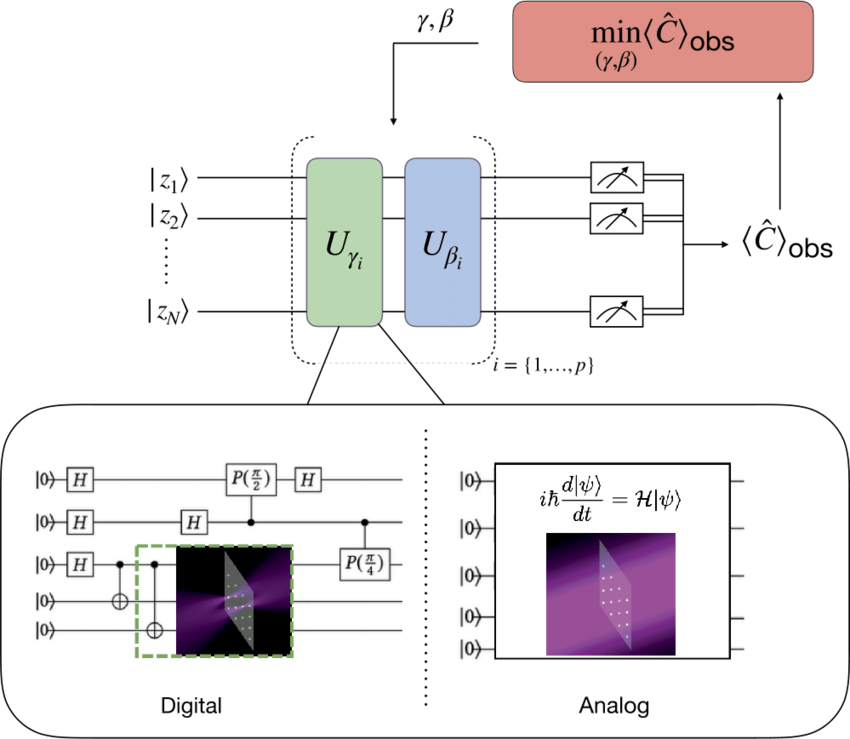

(Follow the Analog part of the image) As shown in the image: all atoms are initially in the groundstate $|00\dots0\rangle$ of the `ground-rydberg` basis.  We then apply $p$ layers of alternating non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_M$, is realized by taking $\Omega = 2\pi$ rad/µs, and $\delta = 0$ rad/µs in the Hamiltonian equation. The second Hamiltonian $H_Q$ is realized with $\Omega =0$ rad/µs and $\delta = \pi$ rad/µs. $H_M$ and $H_Q$ are applied turn in turn with parameters $\tau$ and $t$ respectively. A classical optimizer is then used to estimate the optimal parameters.

# 1. Register preparation

As before, we start by creating a register of atoms. We decide what type of device we will use, the AnalogDevice in this case, set the spacing to 5 $\mu$m and the $\Omega = 2\pi$

In [4]:
device = AnalogDevice
a = 5 #spacing
omega = 2*np.pi
rydberg_radius = device.rydberg_blockade_radius(omega)

We already have a set of coordinates for a specific graph ready and we create a register of qubits out of them like so:

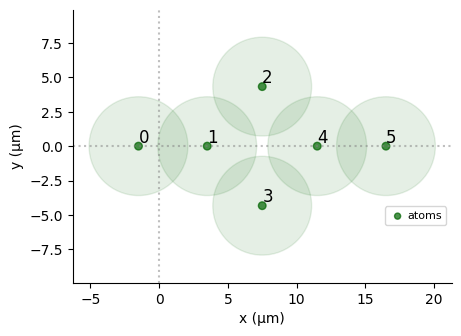

In [6]:
offset = 1.5
coords =[
      [-offset, 0],
      [a-offset, 0],
      [3/2 * a, np.sqrt(3)/2 * a],
      [3/2 * a, -np.sqrt(3)/2 * a],
      [2 * a + offset, 0],
      [3 * a+ offset, 0]
      ]

qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(blockade_radius=rydberg_radius,
    draw_graph=False,
    draw_half_radius=True)

#puccj: when you see two circles intersect it means that the atoms interact between each other, so they are practically connected by a link.
#                             .
# Here the network is:   .__./ \.__.
#                            \./

## 1.1 Graph

We also need a graph object to calculate the classical energy of a bitstring. The famous class networkx is apt for the job. We create a graph object by passing a list of nodes and edges in a very standard way. As you can guess, two nodes will be connected by an edge if their relative distance is lower than the rydberg radius.

In [7]:
G = nx.Graph()
edges=[]
distances = []
for n in range(len(coords)-1):
  for m in range(n+1, len(coords)):
      pwd = ((coords[m][0]-coords[n][0])**2
              +(coords[m][1]-coords[n][1])**2)**0.5
      distances.append(pwd)
      if pwd < rydberg_radius:
          # Below rbr, vertices are connected
          edges.append([n,m])
G.add_nodes_from(range(len(coords)))
G.add_edges_from(edges)

You can check yourself that we created a graph object that represents the register:

In [8]:
print(G.nodes)
print(G.edges)

[0, 1, 2, 3, 4, 5]
[(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (4, 5)]


This will be useful later to calculate the energy of bitstrings.

## 1.2 Classical solution

We are dealing with a few qubits and therefore we can calculate the solution to our problem with a brute-force approach: measuring the energy of each possible bistring and select the best one.

The result of a measurement on the quantum computer is simply string of bits, like '101010', so we need a function that given a string it returns its cost, according to the max cut Hamiltonian.

Check yourself that the following function does what we want:

In [9]:
def get_cost_string(string):
        'Receives a string of 0 and 1s and gives back its cost to the MaxCut hamiltonian'
        configuration = [int(i) for i in string]

        #What is happening here?
        configuration = [1-x*2 for x in configuration]
        cost = 0
        for i,edge in enumerate(G.edges):
            cost += (configuration[edge[0]]*configuration[edge[1]])
        return cost

Now run through all possible bitstrings and we save the result as a dictionary of bitstrings with their cost.

In [10]:
from itertools import product
results = {}

string_configurations = list(product(['0','1'], repeat=len(G)))

for string_configuration in  string_configurations:
    single_string = "".join(string_configuration)
    results[single_string] = get_cost_string(string_configuration)

classical_solution = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))

Can you predict which will be a solution and its cost?
In case you don't you can check yourself:

In [11]:
classical_solution

{'010010': -6, '101101': -6}

# 2. Create the quantum circuit

In order to run an optimization we will have to build several different circuit (depending on the differen parameters passed) so we create a function that accepts as input the parameters and returns a simulation object, ready to be ran.

In this notebook we run a version of QAOA that starts with an initial rotation of all the qubits of $e^{-i pi/2 X}$ so that the initial state is $|+\rangle^{\otimes N}$.

Recall also that the pulses in Pulser have a sensitivity of 4 ns.

In [12]:
def create_quantum_circuit(params):
    #The params will be passed a simple array [alpha_1, beta_1, alpha_2, beta_2, ...]
    depth = int(len(params)/2)
    seq = Sequence(reg, device)
    seq.declare_channel('ch','rydberg_global')

    #This is a "new" type of pulse that allows to have Omega on and detuning = 0
    seq.enable_eom_mode("ch", amp_on=omega, detuning_on=0)

    ### FIRST pulse to rotate the qubits e^{-i pi/2 X}
    #Why is the duration 248? (pretend it is 250 because of the sensitivity)
    seq.add_eom_pulse("ch", 248, phase=0.0)

    gammas = params[::2]#Hc
    betas = params[1::2]#Mixing
    seq.declare_variable("params",size=2*depth)
    for i in range(depth):

        #Ensures params are multiples of 4 ns
        beta_i = int(betas[i]) - int(betas[i]) % 4
        gamma_i = int(gammas[i]) - int(gammas[i]) % 4

        seq.delay(gamma_i, "ch")
        seq.add_eom_pulse("ch", duration=beta_i, phase=0.0)
    seq.measure('ground-rydberg')

    simul = Simulation(seq)

    return simul

To see what a typical sequence of pulses looks like we draw an example:

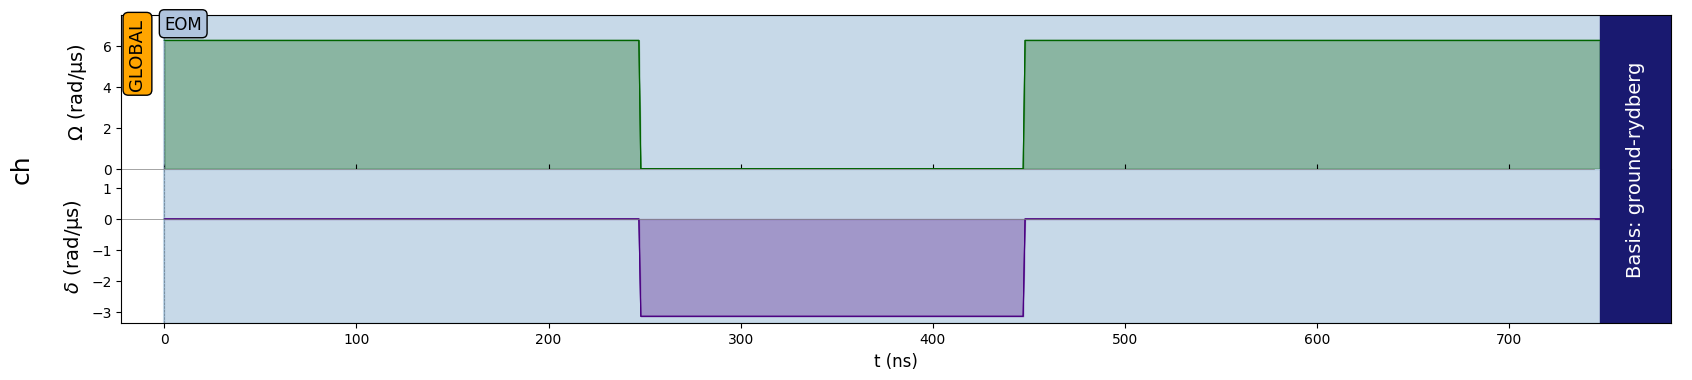

In [14]:
sim_ex =create_quantum_circuit([200,300])
sim_ex.draw()

Now try yourself with another sequence of pulses:

# 3. Creating the Loop

Now that we have a function that builds a circuit with a given set of parameters we need a function that runs it.

Experimentally, we don't have access to the state vector $|\psi\rangle$. We therefore make it more realistic by taking samples from the state vector that results from running the simulation with `simul.run()`. This is done with the built-in method `results.sample_final_state()`, in which we add the measurement basis which was declared at the end of the sequence, and the number of samples desired. Currently, the repetition rate of the machine is $5$ Hz (more or less).

In [15]:
def quantum_loop(parameters):
    params = np.array(parameters)
    simul = create_quantum_circuit(params)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

Let us test it!


In [16]:
example_dict = quantum_loop([200,300])
print(example_dict)

Counter({'100000': 149, '100001': 149, '000000': 143, '000001': 123, '101101': 48, '010001': 44, '000101': 35, '001001': 35, '001000': 34, '000100': 30, '100010': 30, '100100': 29, '101000': 25, '000010': 16, '010000': 16, '010101': 11, '011001': 11, '101001': 9, '100110': 8, '101010': 8, '001101': 7, '100101': 7, '101100': 6, '011000': 5, '011101': 4, '010110': 3, '001010': 2, '001110': 2, '010010': 2, '011010': 2, '101110': 2, '000111': 1, '010011': 1, '010100': 1, '011100': 1, '101111': 1})


## 3.1 Plot the final state

Very conveniently, the built-in function returns a dictionary with:
'bitstring':counts
telling us how many times it measured each bitstring. We can simply print it like that OR we can visualize the final state in a more convenient way:

In [17]:
def plot_distribution(C):
    #sort the dictionary from largest counts to lowest
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))

    #Pick colors for the bars and a different one for the solutions:
    color_dict = {key:"g" for key in C}
    for key in classical_solution.keys():
            val = ''.join(str(key[i]) for i in range(len(key)))
            color_dict[val] = 'r'

    #plot
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

This very useful function we just defined accepts a dictionary of measurements and return a bar plot of it

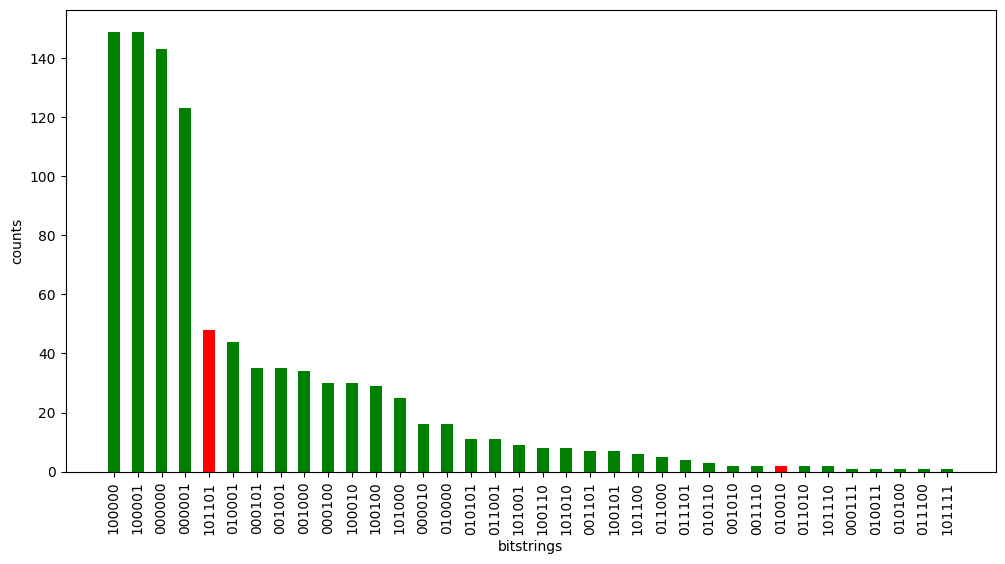

In [18]:
plot_distribution(example_dict)

The bitstrings `101101` `010010` (in red) correspond to the optimal solutions (calculated at the beginning of the notebook). The goal of QAOA is to choregraph interferences between the basis states, in order to maximize the frequency of the optimal solution states.

<b>puccj </b> We want to have the red to the leftmost side of this histogram

## 3. Optimization

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = \sum_{i,j \in E} z_i z_j
$$

That is why we created a graph object with all the edges $E$. Once we know the cost of each measured bitstring, we estimate an average according to each bitstring frequency. Notice that we simply took the quantum Hamiltonian of the Maxcut problem and replaced every $Z$ gate with its classical variable.

For this job we recycle the `get_cost_string` function and we average over it. Check yourself that this is what the function `get_cost` do:

In [19]:
def get_cost(counter):
    cost = 0
    cost += sum(counter[key] * get_cost_string(key) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples, why?

To perform a minimization loop, we define the following function that will be called at each step by SciPy. In fact the minimization methods require a function that accepts the parameters to be optimized and return a real number, we often call it a wrap up function because it encapsulate with a few lines the whole program we built until now:

In [20]:
costs = []

def func(param):
    C = quantum_loop(param)
    cost = get_cost(C)
    print('params: ', param, 'cost: ', cost)
    costs.append(cost)
    return cost

We are also saving the costs so that we can plot them later

### QAOA for depth $p = 2$

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the QUBO $Q$ and an initial point `x0` for the simplex in Nelder-Mead minimization. As the optimizer might get trapped in local minima, we repeat the optimization 20 times and select the parameters that yield the best approximation ratio.

In [21]:
depth = 2
starting_point = np.random.uniform(100, 1000, depth*2)
res = minimize(
    func,
    x0=starting_point,
    method="Nelder-Mead",
    tol=1e-5,
    options={"maxiter": 10},
)

params:  [210.49761874 117.26381221 196.15308906 293.86487186] cost:  2.496
params:  [221.02249968 117.26381221 196.15308906 293.86487186] cost:  2.456
params:  [210.49761874 123.12700282 196.15308906 293.86487186] cost:  2.308
params:  [210.49761874 117.26381221 205.96074352 293.86487186] cost:  2.458
params:  [210.49761874 117.26381221 196.15308906 308.55811545] cost:  2.216
params:  [215.76005921 120.19540751 201.05691629 301.21149365] cost:  2.15
params:  [218.39127944 121.66120516 203.5088299  304.88480455] cost:  2.144
params:  [219.70688956 122.39410399 190.02330503 306.72146   ] cost:  2.048
params:  [224.31152497 124.95924988 182.05458579 313.14975407] cost:  2.076
params:  [208.52420356 124.95924988 196.76606747 313.14975407] cost:  1.706
params:  [202.27505551 128.80696872 197.07255667 322.79219518] cost:  1.584
params:  [214.93780289 121.93604222 197.22580127 327.61341574] cost:  1.496
params:  [217.15789496 121.34056193 197.76215737 344.48768767] cost:  0.93
params:  [218.

We can now plot the sample that we woud obtain using the optimal variational parameters.

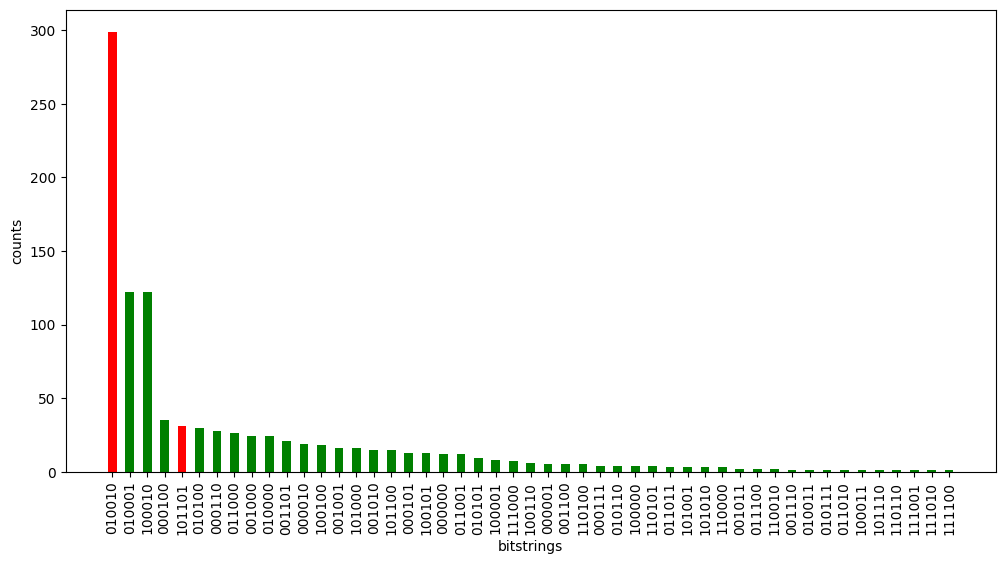

In [22]:
optimal_count_dict = quantum_loop(res.x)
plot_distribution(optimal_count_dict)

Now we can also check the optimization route that our optimizer took in the parameters landscape:

\

Text(0.5, 0, 'Steps')

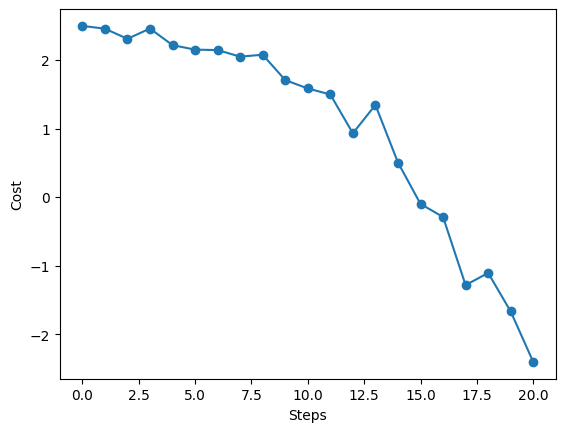

In [23]:
plt.plot(range(len(costs)), costs, 'o-')
plt.ylabel('Cost')
plt.xlabel('Steps')

# 4. Try yourself

Now you can try to play around with QAOA. Change the depth, change otpimizer ...